In [1]:
!pip install pycaret

In [2]:
from pycaret.datasets import get_data
data = get_data('insurance')

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Data Preparation

In [3]:
from pycaret.regression import *
s = setup(data, target = 'charges', session_id = 123)

,Description,Value
0,Session id,123
1,Target,charges
2,Target type,Regression
3,Original data shape,"(1338, 7)"
4,Transformed data shape,"(1338, 10)"
5,Transformed train set shape,"(936, 10)"
6,Transformed test set shape,"(402, 10)"
7,Numeric features,3
8,Categorical features,3
9,Preprocess,True


In [4]:
# check transformed X_train
get_config('X_train')

,age,sex,bmi,children,smoker,region
300,36,male,27.549999,3,no,northeast
904,60,female,35.099998,0,no,southwest
670,30,male,31.570000,3,no,southeast
617,49,male,25.600000,2,yes,southwest
373,26,male,32.900002,2,yes,southwest
...,...,...,...,...,...,...
1238,37,male,22.705000,3,no,northeast
1147,20,female,31.920000,0,no,northwest
106,19,female,28.400000,1,no,southwest
1041,18,male,23.084999,0,no,northeast


In [5]:
# list columns of transformed X_train
get_config('X_train').columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

## Model Training & Selection

#### Compare Models

In [6]:
# train all models using default hyperparameters
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,2701.9927,23548981.3626,4832.9682,0.8320,0.4447,0.3137,0.1910
rf,Random Forest Regressor,2771.4583,25416502.3827,5028.6343,0.8172,0.4690,0.3303,0.2720
lightgbm,Light Gradient Boosting Machine,2992.1828,25521038.3331,5042.0978,0.8149,0.5378,0.3751,0.4900
et,Extra Trees Regressor,2833.3624,28427844.2412,5305.6516,0.7991,0.4877,0.3363,0.2260
ada,AdaBoost Regressor,4316.0568,29220505.6498,5398.4561,0.7903,0.6368,0.7394,0.0700
xgboost,Extreme Gradient Boosting,3278.3216,31628234.0000,5599.0988,0.7709,0.5733,0.4208,0.0950
br,Bayesian Ridge,4311.2349,38391950.0874,6176.8896,0.7306,0.5910,0.4447,0.0650
llar,Lasso Least Angle Regression,4303.7694,38386824.2786,6176.4846,0.7306,0.5952,0.4434,0.0660
lr,Linear Regression,4303.5559,38388058.4578,6176.5920,0.7306,0.5949,0.4433,0.6730
lar,Least Angle Regression,4303.5559,38388058.4578,6176.5920,0.7306,0.5949,0.4433,0.0780


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [7]:
print(best)

GradientBoostingRegressor(random_state=123)


In [8]:
type(best)

sklearn.ensemble._gb.GradientBoostingRegressor

## Create Model

In [9]:
# train individual model
dt = create_model('dt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3244.6173,45002914.9978,6708.4212,0.7312,0.5884,0.4883
1,3121.3069,45456737.6696,6742.1612,0.7357,0.5398,0.3300
2,3646.2662,54445682.2627,7378.7318,0.3107,0.6475,0.4752
3,3228.2250,44536493.7924,6673.5668,0.6281,0.5698,0.4253
4,4344.7470,65261429.3013,8078.4546,0.5146,0.7261,0.6008
5,3497.9281,42984919.0254,6556.2885,0.7235,0.4614,0.3208
6,3464.9372,51736922.8950,7192.8383,0.6480,0.5064,0.3792
7,2804.7111,37461846.7208,6120.6084,0.7940,0.4737,0.1787
8,3080.1801,42102090.8846,6488.6124,0.7281,0.5168,0.4537


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
print(dt)

DecisionTreeRegressor(random_state=123)


## Tune Hyperparameters

In [11]:
!pip install "pycaret[tuners]"

In [12]:
# tune hyperparameters of model
tuned_dt = tune_model(dt, search_library = 'optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2326.2012,21826102.1048,4671.8414,0.8696,0.4337,0.2190
1,2655.5258,33371854.0872,5776.8377,0.8060,0.4647,0.1885
2,2355.9701,21549640.5603,4642.1590,0.7272,0.5092,0.2672
3,2227.8986,21396360.2440,4625.6200,0.8213,0.4046,0.2247
4,2784.8044,31088928.4616,5575.7447,0.7688,0.4567,0.1914
5,2146.3860,19685469.3167,4436.8310,0.8734,0.3864,0.1633
6,2018.6181,22605561.0367,4754.5306,0.8462,0.3476,0.1685
7,2730.5112,25110551.4939,5011.0430,0.8619,0.4958,0.3255
8,2213.8963,23461094.4714,4843.6654,0.8485,0.4113,0.1829


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 936 samples...
INFO:optuna_integration.sklearn.sklearn:Finished hyperparameter search!


In [13]:
print(tuned_dt)

DecisionTreeRegressor(criterion='absolute_error', max_depth=5,
                      max_features=0.5878059747489457,
                      min_impurity_decrease=0.0013694571785533313,
                      min_samples_leaf=4, min_samples_split=9,
                      random_state=123)


## Ensemble Model

In [14]:
bagged_tunned_dt = ensemble_model(tuned_dt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1867.0081,19352373.5161,4399.1333,0.8844,0.3392,0.1361
1,2579.6444,33276356.2824,5768.5662,0.8065,0.4539,0.1729
2,1969.1160,20631128.0973,4542.1502,0.7388,0.4473,0.1799
3,1959.5648,19211606.4259,4383.1047,0.8396,0.3569,0.1641
4,2415.3631,27337734.6237,5228.5500,0.7967,0.4552,0.1594
5,2255.0578,21980078.1977,4688.2916,0.8586,0.3612,0.1567
6,1871.0124,22856234.1821,4780.8194,0.8445,0.3310,0.1276
7,2561.5820,28928836.0926,5378.5533,0.8409,0.4419,0.1636
8,2133.9000,22958787.0439,4791.5328,0.8517,0.3844,0.2104


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [15]:
print(bagged_tunned_dt)

BaggingRegressor(estimator=DecisionTreeRegressor(criterion='absolute_error',
                                                 max_depth=5,
                                                 max_features=0.5878059747489457,
                                                 min_impurity_decrease=0.0013694571785533313,
                                                 min_samples_leaf=4,
                                                 min_samples_split=9,
                                                 random_state=123),
                 random_state=123)


## Voting Ensemble

In [16]:
dt = create_model('dt', verbose=False)
lasso = create_model('lasso', verbose=False)
knn = create_model('knn', verbose=False)
blender = blend_models([dt,lasso,knn])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,4527.3203,41494217.0353,6441.6005,0.7522,0.5725,0.5763
1,4759.4731,49228124.1300,7016.2757,0.7138,0.5688,0.4793
2,3857.8892,34479562.7027,5871.9301,0.5634,0.6095,0.5399
3,4403.3843,37822580.8675,6150.0066,0.6842,0.6289,0.6820
4,4857.8894,49497599.6660,7035.4531,0.6319,0.6180,0.5889
5,4208.3491,39163045.2934,6258.0385,0.7481,0.4455,0.3805
6,4343.5564,45472791.3646,6743.3516,0.6906,0.5449,0.5167
7,4102.8929,40852436.3768,6391.5911,0.7754,0.4653,0.3270
8,4614.8428,45051485.4789,6712.0403,0.7090,0.5852,0.6356


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
print(blender)

VotingRegressor(estimators=[('Decision Tree Regressor',
                             DecisionTreeRegressor(random_state=123)),
                            ('Lasso Regression', Lasso(random_state=123)),
                            ('K Neighbors Regressor',
                             KNeighborsRegressor(n_jobs=-1))],
                n_jobs=-1)


In [18]:
type(blender)

sklearn.ensemble._voting.VotingRegressor

## Stacking Ensemble

In [19]:
stacker = stack_models([dt,lasso,knn])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3379.8887,26876488.7224,5184.2539,0.8395,0.4928,0.4251
1,3704.6673,34884631.7826,5906.3213,0.7972,0.5104,0.3418
2,3468.8303,32189132.0760,5673.5467,0.5924,0.5568,0.4021
3,3277.0324,25395854.6438,5039.4300,0.7879,0.5696,0.4639
4,4183.7481,41473790.7186,6440.0148,0.6915,0.5836,0.4455
5,3424.8805,27482764.5775,5242.4007,0.8232,0.5125,0.3384
6,3566.2841,33477674.9367,5785.9895,0.7722,0.4616,0.3766
7,3704.0011,32338475.1918,5686.6928,0.8222,0.4814,0.2837
8,3607.8196,27390163.4322,5233.5613,0.8231,0.5479,0.4488


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [20]:
print(stacker)

StackingRegressor(cv=5,
                  estimators=[('Decision Tree Regressor',
                               DecisionTreeRegressor(random_state=123)),
                              ('Lasso Regression', Lasso(random_state=123)),
                              ('K Neighbors Regressor',
                               KNeighborsRegressor(n_jobs=-1))],
                  final_estimator=LinearRegression(n_jobs=-1), n_jobs=-1)


## Analyze Model

In [21]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

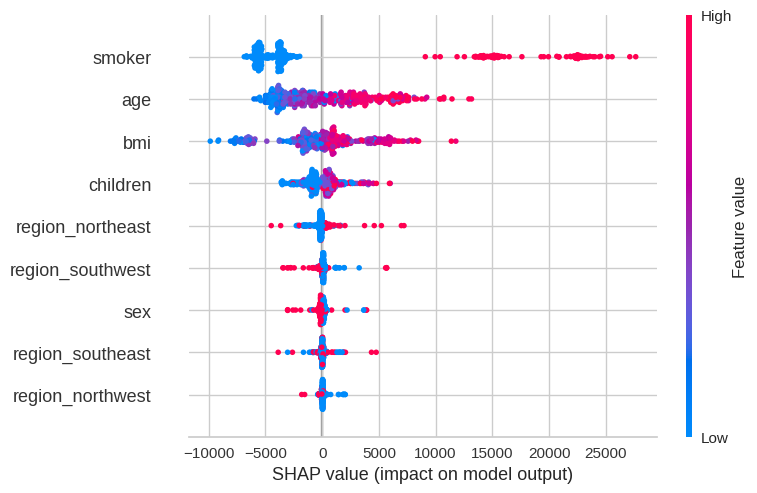

In [22]:
interpret_model(dt)

In [23]:
interpret_model(dt, plot = 'reason', observation=1)

## Model Predictions

In [24]:
# predict on holdout / test set
pred_holdout = predict_model(best);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,2392.5661,17148355.3169,4141.0573,0.8800,0.3928,0.2875


In [25]:
pred_holdout.head()

,age,sex,bmi,children,smoker,region,charges,prediction_label
650,49,female,42.680000,2,no,southeast,9800.888672,10681.513104
319,32,male,37.334999,1,no,northeast,4667.607422,8043.453463
314,27,female,31.400000,0,yes,southwest,34838.871094,36153.097686
150,35,male,24.129999,1,no,northwest,5125.215820,7435.516853
336,60,male,25.740000,0,no,southeast,12142.578125,14676.544334


In [26]:
# predict on new data
data2 = data.copy()
data2.drop('charges', axis=1, inplace=True)
data2.head()

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest


In [27]:
# finalize model
best_final = finalize_model(best)

In [28]:
# predict on data2
predictions = predict_model(best_final, data=data2)
predictions.head()

,age,sex,bmi,children,smoker,region,prediction_label
0,19,female,27.900000,0,yes,southwest,19270.248258
1,18,male,33.770000,1,no,southeast,3715.049011
2,28,male,33.000000,3,no,southeast,6492.553971
3,33,male,22.705000,0,no,northwest,5686.393327
4,32,male,28.879999,0,no,northwest,3744.189014
